In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights
from PIL import Image
from tqdm.auto import tqdm

import numpy as np

import lovely_tensors as lt
lt.monkey_patch()

from pathlib import Path
Path.ls = lambda x: list(x.iterdir())

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.eval()
model = model.to(device)

transform = ResNet18_Weights.IMAGENET1K_V1.transforms()

images_dir = Path('../data/example_images')
len(images_dir.ls())

50

tensor[1, 3, 224, 224] n=150528 (0.6Mb) x∈[-1.947, 2.570] μ=-0.114 σ=0.534 cuda:0


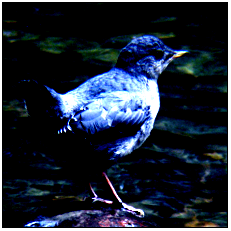

In [3]:
image = Image.open(images_dir.ls()[0])
t_image = transform(image).to(device)
batch = t_image.unsqueeze(0)
print(batch)
batch.rgb

In [4]:
import torch

means = torch.tensor([0.485, 0.456, 0.406]).to(device)
stds = torch.tensor([0.229, 0.224, 0.225]).to(device)

def norm(batch):
    return (batch - means.view(1, -1, 1, 1)) / stds.view(1, -1, 1, 1)

def denorm(batch):
    return batch * stds.view(1, -1, 1, 1) + means.view(1, -1, 1, 1)

def get_class_conf(model, batch):
    with torch.inference_mode():
        output = F.softmax(model(batch), dim=1)
        res_class_id = torch.argmax(output, 1)
        res_conf = output.gather(1, res_class_id[..., None])

        return res_class_id[0].item(), res_conf[0][0].item()


ref_class_id, ref_conf = get_class_conf(model, batch)
print(f"Started class was: {ref_class_id}, with confidence: {ref_conf:.6f}")

Started class was: 20, with confidence: 0.998181


In [66]:
import torch.nn.functional as F

# Access the target layer directly
target_layer = model.layer4[0].conv2

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output#.detach()
    return hook


image = Image.open(images_dir.ls()[0])
t_image = transform(image).to(device)
batch = t_image.unsqueeze(0).requires_grad_(True)  # Enable gradients for the input
print(batch)

epsilon = 0.0007

hook = target_layer.register_forward_hook(get_activation('layer4.0.conv2'))
target_tensor = torch.tensor([0], dtype=torch.long, device=device)

for i in range(5000):
    model.zero_grad()
    
    res = model(batch)

    loss_adv = -F.cross_entropy(res, target_tensor)
    loss_act = -activation['layer4.0.conv2'].mean()

    loss = loss_act + loss_adv

    loss.backward()

    data_grad = batch.grad.data

    sign_data_grad = data_grad.sign()
    batch.data = batch.data + epsilon * sign_data_grad

    if i % 100 == 0:
        print(f"Loss: {loss.item()}")
    

hook.remove()

tensor[1, 3, 224, 224] n=150528 (0.6Mb) x∈[-1.947, 2.570] μ=-0.114 σ=0.534 grad cuda:0
Loss: -19.993146896362305
Loss: 0.14653463661670685
Loss: 0.1572418063879013
Loss: 0.1514841616153717
Loss: 0.15072360634803772
Loss: 0.14830033481121063
Loss: 0.14338742196559906
Loss: 0.13831046223640442
Loss: 0.13658298552036285
Loss: 0.1363459825515747
Loss: 0.13327370584011078
Loss: 0.13082003593444824
Loss: 0.12647518515586853
Loss: 0.1218915581703186
Loss: 0.1173446998000145
Loss: 0.11423351615667343
Loss: 0.1143300011754036
Loss: 0.11384262144565582
Loss: 0.11273287236690521
Loss: 0.10976556688547134
Loss: 0.10652941465377808
Loss: 0.10311949998140335
Loss: 0.10258668661117554
Loss: 0.10415834933519363
Loss: 0.10568831861019135
Loss: 0.10534027963876724
Loss: 0.10153081268072128
Loss: 0.09840281307697296
Loss: 0.10028369724750519
Loss: 0.10613974928855896
Loss: 0.10953397303819656
Loss: 0.10877959430217743
Loss: 0.11032070964574814
Loss: 0.11666865646839142
Loss: 0.1196671575307846
Loss: 0.12

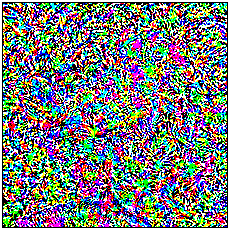

In [68]:
batch.rgb

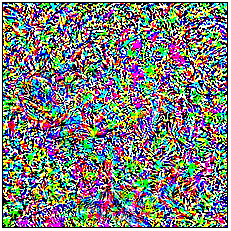

In [67]:
denorm(batch).rgb

In [36]:
loss

tensor grad NegBackward0 cuda:0 0.165

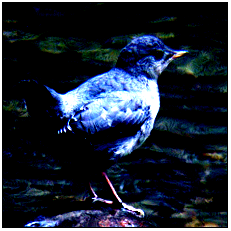

In [30]:
print("Requires grad:", batch.requires_grad)  # This should print True

# Proceed with the forward pass
res = model(batch)

# Compute loss
loss = -activation['layer4.0.conv2'].mean()
print("Loss requires grad:", loss.requires_grad)  # This should also print True

# Attempt the backward pass
loss.backward()


Requires grad: True
Loss requires grad: False


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

tensor[1, 1000] 3.9Kb x∈[-5.610, 19.042] μ=2.367e-05 σ=2.249 grad AddmmBackward0 cuda:0

In [9]:
-activation['layer4.0.conv2'].mean()

# Zero gradients
model.zero_grad()

# Backward pass to calculate gradients
loss.backward()

NameError: name 'loss' is not defined

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [87]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [114]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torchvision.transforms import functional as TF
import numpy as np

# Load a pre-trained ResNet-18 model
# model = models.resnet18(pretrained=True).eval()vgg19
model = models.vgg19(pretrained=True).eval()
model.to(device)

# Define the DeepDream class
class DeepDream:
    def __init__(self, model):
        self.model = model
        self.gradients = None

    # Hooks for the gradients
    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # first_layer = list(model.children())[7]
        first_layer = list(model.children())[1]
        # first_layer = list(model.children())[0]
        first_layer.register_full_backward_hook(hook_function)

    # Recursive function to apply Deep Dream
    def dream(self, image, iterations, lr, max_rotation=90):
        """
        Apply the Deep Dream process to an image.
    
        Args:
        - image: the image to process, as a PyTorch tensor.
        - iterations: the number of iterations to apply the Deep Dream process.
        - lr: the learning rate (step size) for each iteration.
        - max_rotation: the maximum rotation angle in degrees for the random rotation. Default is 15 degrees.
    
        Returns:
        - The processed image as a PyTorch tensor.
        """
        target_tensor = torch.tensor([20], dtype=torch.long, device=device)

        for _ in tqdm(range(iterations)):
            # Random rotation
            angle = np.random.uniform(-max_rotation, max_rotation)
            image = TF.rotate(image, 90, interpolation=transforms.InterpolationMode.BILINEAR)
            image.requires_grad = True
            self.model.zero_grad()
            self.hook_layers()
            output = self.model(image)
            loss_adv = -F.cross_entropy(output, target_tensor)
            loss = output.norm() + loss_adv
            loss.backward()
            # Update image with gradients, applied to the original image to maintain quality
            image = image + lr * image.grad
            image = image.detach()
        return image.detach()

    # Function to preprocess the image
    def preprocess_image(self, image_path):
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
        image = Image.open(image_path)
        image = transform(image).unsqueeze(0).to(device)
        return image

    # Function to recreate the image
    def recreate_image(self, processed_image):
        image = processed_image.squeeze(0).cpu().detach().numpy()
        image = image.transpose(1, 2, 0)
        image = image * 255
        image = np.clip(image, 0, 255).astype(np.uint8)
        return Image.fromarray(image)

tensor[1, 3, 224, 224] n=150528 (0.6Mb) x∈[1.987e-06, 1.000] μ=0.499 σ=0.289 cuda:0

  0%|          | 0/1000 [00:00<?, ?it/s]

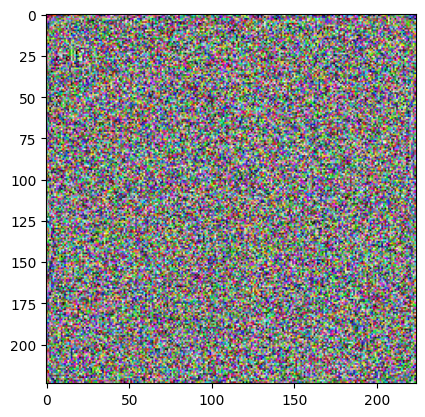

In [118]:
#Initialize DeepDream with our model
deep_dream = DeepDream(model)

# Preprocess the image
image_path = images_dir.ls()[0]  # Change this to your image path
# processed_image = deep_dream.preprocess_image('../photo_2022-08-16_14-54-59 (2).jpg')
processed_image = deep_dream.preprocess_image(image_path)
processed_image = torch.rand_like(processed_image)
# Apply Deep Dream
dreamed_image = deep_dream.dream(processed_image, iterations=1000, lr=.002)

# Recreate and visualize the dreamed image
final_image = deep_dream.recreate_image(dreamed_image)
plt.imshow(final_image)
plt.show()

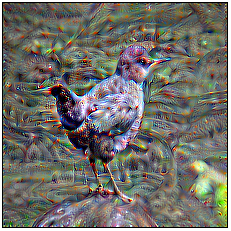

In [64]:
dreamed_image.rgb